In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re

/home/laurinemeier/anaconda3/envs/swerick/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [4]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to("cpu")

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [5]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [6]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 762794
    })
})

In [7]:
valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [8]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

ok


In [9]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [10]:
config = transformers.BertConfig.from_pretrained("pretraining_from_scratch/checkpoint-841424")
mosaicBert = AutoModelForMaskedLM.from_pretrained("pretraining_from_scratch/checkpoint-841424",config=config,trust_remote_code=True)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-841424/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [15]:
pipe = pipeline(task="fill-mask", model=mosaicBert, tokenizer=swerick_tokenizer)
pipe("Hey [MASK]")

[{'score': 0.03553388640284538,
  'token': 18,
  'token_str': '.',
  'sequence': 'Hey.'},
 {'score': 0.030466275289654732,
  'token': 16,
  'token_str': ',',
  'sequence': 'Hey,'},
 {'score': 0.020780669525265694,
  'token': 373,
  'token_str': 'att',
  'sequence': 'Hey att'},
 {'score': 0.01568838395178318,
  'token': 75,
  'token_str': 'i',
  'sequence': 'Hey i'},
 {'score': 0.015056636184453964,
  'token': 387,
  'token_str': 'och',
  'sequence': 'Hey och'}]

In [18]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-858750")
model_hugging_face=model_hugging_face.to("cpu")

In [17]:
with open("valid_scratch.pkl","rb") as f :
    valid_data = pickle.load(f)

In [18]:
data_collector =preprocessing.data_collector_masking(tokenizer,0.15)
valid_data = valid_data.remove_columns(["word_ids","token_type_ids"])
valid_scratch_loader =preprocessing.create_deterministic_eval_dataset(valid_data["valid"],data_collator)
valid_scratch_loader =preprocessing.create_dataloader(valid_scratch_loader,64,default_data_collator)

cls.predictions.transform.LayerNorm.weight


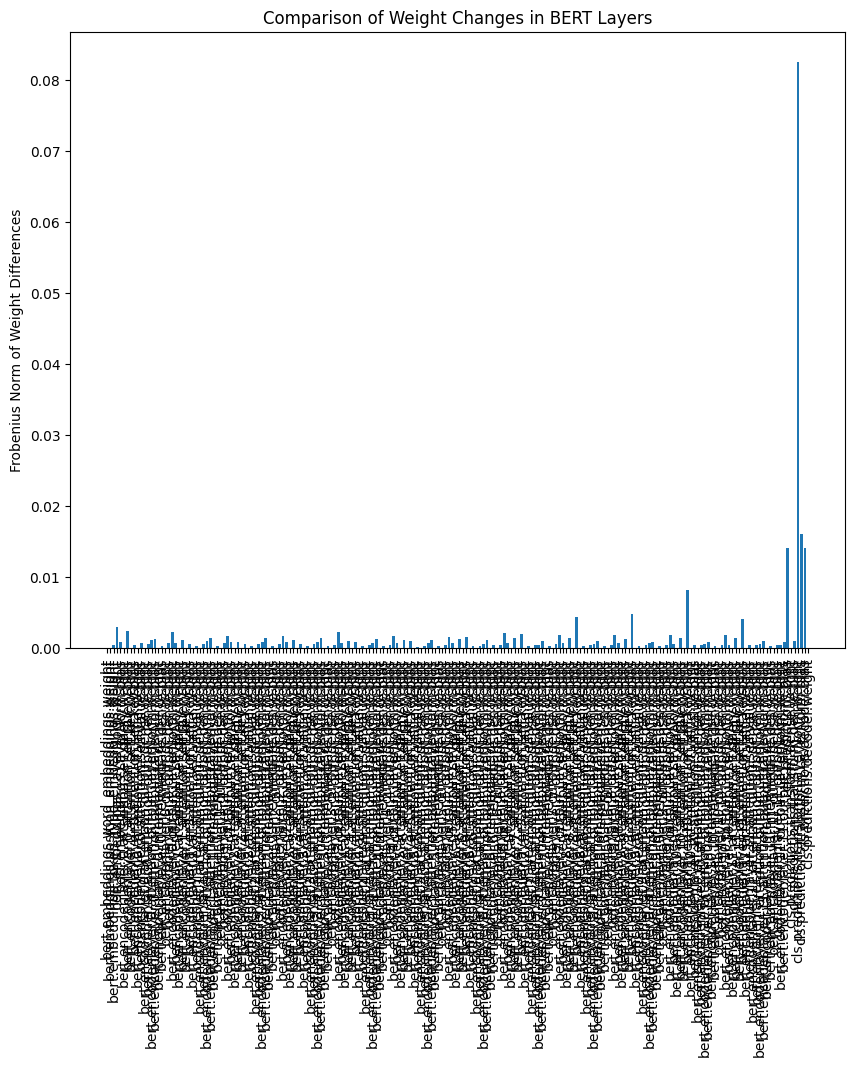

In [14]:
# Comparaison of weights for different models
import matplotlib.pyplot as plt
import numpy as np

def get_model_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.detach().cpu().numpy()
    return weights


weights_kb = get_model_weights(model_kb)
weights_finetuned = get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    if (np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) > 0.04 :
        print(key)
    #     print(np.linalg.norm(weight_diffs[key],2))
    #     print(weight_diffs[key].size)
    #     print( np.linalg.norm(weight_diffs[key])/weight_diffs[key].size)
    

weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy()
norms = [(np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) for key in weight_diffs.keys()]

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms, tick_label=list(weight_diffs.keys()))
plt.xticks(rotation=90)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()  

['checkpoint-343500', 'checkpoint-400750', 'checkpoint-458000', 'checkpoint-515250', 'checkpoint-572500', 'checkpoint-629750', 'checkpoint-687000', 'checkpoint-744250', 'checkpoint-801500', 'checkpoint-858750', 'checkpoint-916000', 'checkpoint-973250', 'checkpoint-1030500', 'checkpoint-1087750', 'checkpoint-1145000', 'checkpoint-1202250', 'checkpoint-1259500', 'checkpoint-1316750', 'checkpoint-1374000', 'checkpoint-1431250', 'checkpoint-1488500', 'checkpoint-1545750', 'checkpoint-1603000', 'checkpoint-1660250', 'checkpoint-1717500', 'checkpoint-1774750', 'checkpoint-1832000', 'checkpoint-1889250', 'checkpoint-1946500', 'checkpoint-2003750', 'checkpoint-2061000', 'checkpoint-2118250', 'checkpoint-2175500', 'checkpoint-2232750', 'checkpoint-2290000', 'checkpoint-2347250', 'checkpoint-2404500', 'checkpoint-2461750', 'checkpoint-2519000', 'checkpoint-2576250', 'checkpoint-2633500', 'checkpoint-2690750', 'checkpoint-2748000', 'checkpoint-2805250', 'checkpoint-2862500', 'checkpoint-2919750',

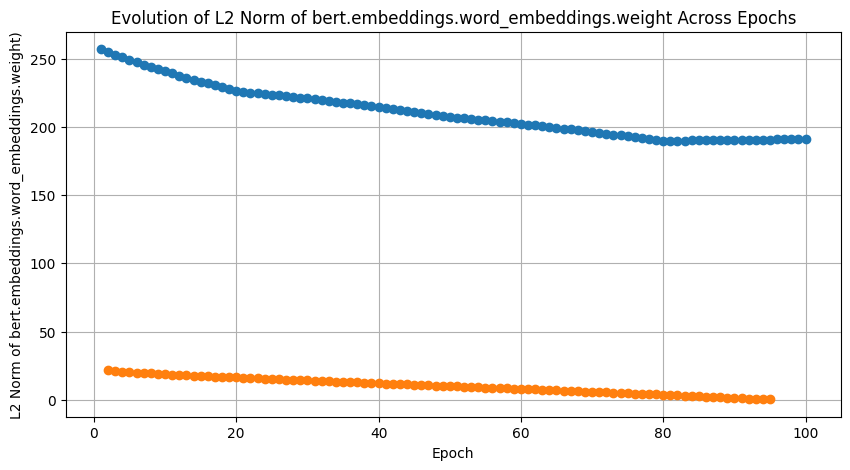

In [33]:
#Evolution of a specific layer through epochs
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
print(checkpoint_files)

bias_norms = []
drift=[]
bias_weight=model_kb.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
print(np.linalg.norm(bias_weight))

for checkpoint in checkpoint_files:
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    ref_weight = bias_weight
    bias_weight = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    norm = np.linalg.norm(bias_weight)
    bias_norms.append(norm)
    drift.append(np.linalg.norm(bias_weight - ref_weight))
    

epochs = list(range(1, len(bias_norms) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, bias_norms, marker='o')
plt.plot(epochs[1:95], drift[1:95], marker='o')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of bert.embeddings.word_embeddings.weight)')
plt.title('Evolution of L2 Norm of bert.embeddings.word_embeddings.weight Across Epochs')
plt.grid(True)
plt.show()

Study of Word Embedding

In [34]:
# Token present in the training dataset

token_frequencies = Counter()


for example in lm_datasets["train"]:
    token_frequencies.update(example['input_ids'])

NameError: name 'Counter' is not defined

In [ ]:
#Most frequent token

n = int(len(token_frequencies.keys())*0.8) 
most_common_tokens = token_frequencies.most_common(n)
most_common_ids, most_common_freqs = zip(*most_common_tokens)
most_common_ids_tensor = torch.tensor(most_common_ids)

print("Les IDs des tokens les plus fréquents et leurs fréquences :")
for token_id, freq in zip(most_common_ids, most_common_freqs):
    print(f"Token ID: {token_id}, Fréquence: {freq}")

In [ ]:
#change in embedding 
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5725000")
model_hugging_face=model_hugging_face.to(device)
ref_weight = model_kb.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
bias_weight = model_hugging_face.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
embedding_changes = torch.norm(bias_weight - ref_weight, dim=1)

unk_index = tokenizer.convert_tokens_to_ids('[UNK]')
pad_index =  tokenizer.convert_tokens_to_ids('[PAD]')
print(pad_index)
print(embedding_changes[unk_index])
print(embedding_changes[pad_index])
values, top_indices = torch.topk(embedding_changes, 100)

# Convert indices to tokens
top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
print(values)
# Print the results
print("Top 25 words with the most changed embeddings vectors:")
for word in top_words:
    print(word)

In [ ]:
# Graph represent the most changed word embedding thorugh epochs

checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
epoch_data = {}
word_color = {}
total_frequencies = {}
initial_embeddings = model_kb.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
colors = plt.cm.viridis(np.linspace(0, 1, 5))
# Training loop
epoch=4
for checkpoint in checkpoint_files:
    epoch +=1
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    model=model.to(device)
    #initial_embeddings = embeddings
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]

    embedding_changes = torch.norm(embeddings - initial_embeddings, dim=1)
    
    # Get the top 5 changes
    _, top_indices = torch.topk(embedding_changes, 1)
    top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
    top_changes = embedding_changes[top_indices].tolist()
    for word in top_words:
            if word not in word_color:
                word_color[word] = colors[len(word_color) % len(colors)]
            if word not in total_frequencies :
                total_frequencies[word] =1
            if word  in total_frequencies :
                total_frequencies[word] +=1
        
    # Store data
    epoch_data[epoch] = list(zip(top_words, top_changes))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
already_labeled = set()
for epoch in epoch_data:
    words, changes = zip(*epoch_data[epoch])
    if words[0] not in already_labeled:
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]],label=words[0])
        already_labeled.add(words[0])
    else : 
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]])

ax.set_xlabel('Epoch')
ax.set_ylabel('Change in Norm of Embeddings')
ax.set_title('Most changed word embedding by Epoch')
ax.legend()
plt.show()

bert.encoder.layer.8.attention.self.key.bias
864.7038534997006
864.7038534997006
bert.encoder.layer.9.attention.self.key.bias
960.6252920930923
960.6252920930923
bert.encoder.layer.10.attention.self.key.bias
1546.8516204587545
1546.8516204587545
bert.encoder.layer.11.attention.self.key.bias
905.0282882048377
905.0282882048377
cls.predictions.bias
1881.7153401337032
1881.7153401337032


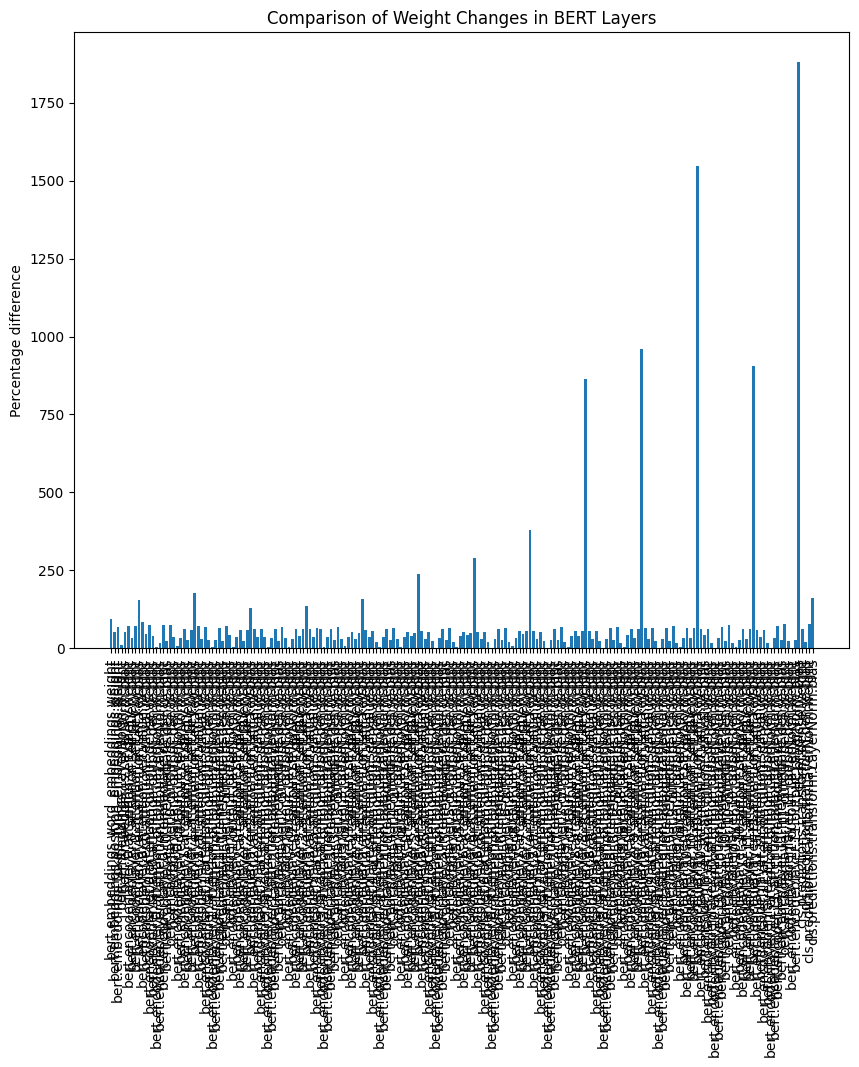

In [15]:
#Percentage difference between layers
def get_model_weight_bis(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.detach().cpu().numpy().flatten()
    return weights


weights_kb = get_model_weight_bis(model_kb)
weights_finetuned = get_model_weight_bis(model_hugging_face)
weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy().flatten() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy().flatten()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy().flatten() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy().flatten()

# Initialize lists to store all percent differences
percent_differences = {}
epsilon = 1e-6 
# Calculate percent differences for each corresponding weight
for key in weights_kb:
    if key in weights_finetuned:  # Ensure the key exists in both models
        weight_kb = weights_kb[key]
        weight_ft = weights_finetuned[key]
        # Compute percent difference only where the initial weights are not zero to avoid division by zero
        percent_diff = 100*np.linalg.norm(weight_ft - weight_kb) / np.linalg.norm(weight_kb)
        #percent_diff = np.abs(weight_ft-weight_kb)
        
        percent_differences[key]=np.mean(percent_diff) # Append differences to the list
        if percent_differences[key] >500 :
            print(key)
            print(percent_diff)
            print(percent_differences[key])
        

# Plotting the histogram of percent differences
percent = [percent_differences[key] for key in percent_differences.keys()]


plt.figure(figsize=(10, 8))
plt.bar(range(len(percent)), percent, tick_label=list(percent_differences.keys()))
plt.xticks(rotation=90)
plt.ylabel('Percentage difference')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show() 

In [6]:
from datasets import Dataset
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])
valid_dataset=preprocessing.create_deterministic_eval_dataset(Dataset.from_dict(valid_dataset["valid"][:10000]),data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,64,default_data_collator)

Map: 100%|██████████| 10000/10000 [00:02<00:00, 4743.06 examples/s]


Layer-wise cosine similarities: [0.69033222 0.77607266 0.75952113 0.73877175 0.72133737 0.70752271
 0.69520003 0.68212404 0.66867383 0.66504747 0.65335075 0.63036022
 0.55031005]


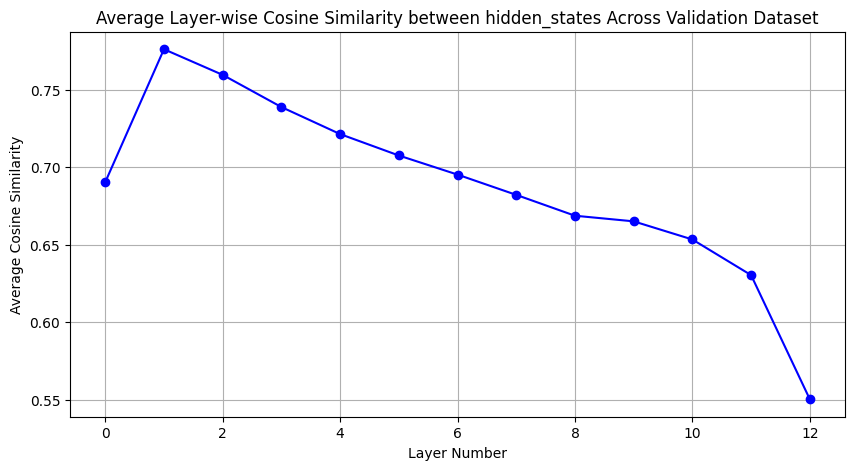

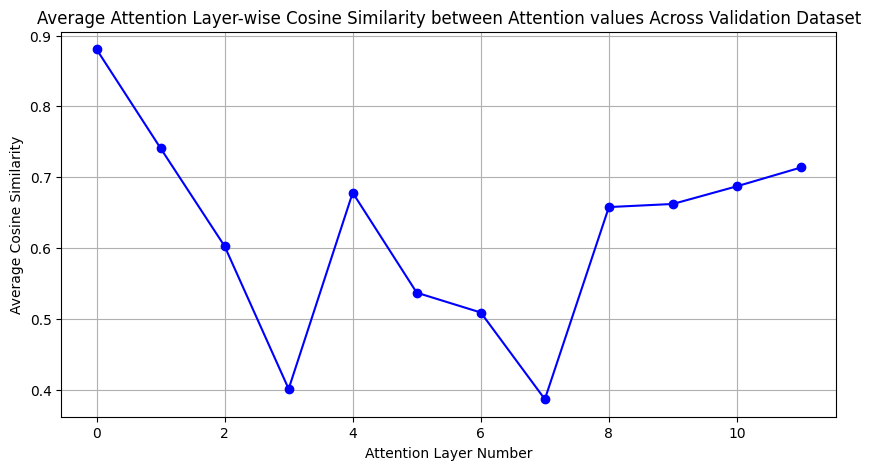

In [9]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np


def extract_activations(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    return hidden_states

def extract_and_compare_activations(model_pre, model_post, dataloader):
    similarities_hidden_states = []
    similarities_attention=[]
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        with torch.no_grad():
            pre_output= model_pre(**batch, output_hidden_states=True, output_attentions=True)
            pre_activations = pre_output.hidden_states
            pre_attention = pre_output.attentions
            post_output = model_post(**batch, output_hidden_states=True,output_attentions=True)
            post_activations = post_output.hidden_states
            post_attention = post_output.attentions
            #pre_logits= pre_output[1]
            #post_logits = post_output[1]
       
        example_similarities_hidden_states = [cosine_similarity(pre_activations[layer], post_activations[layer]) for layer in range(len(pre_activations))]
        #example_similarities_hidden_states.append(cosine_similarity(pre_logits,post_logits))
        example_similarities_attention = [cosine_similarity(pre_attention[layer], post_attention[layer]) for layer in range(len(pre_attention))]
        del pre_output
        del post_output
        del pre_attention
        del post_attention
       # del pre_logits
       # del post_logits
        similarities_hidden_states.append(example_similarities_hidden_states)
        similarities_attention.append(example_similarities_attention)
    
    mean_similarities_hidden_states = np.mean(similarities_hidden_states, axis=0)
    mean_similarities_attention = np.mean(similarities_attention, axis=0)
    return mean_similarities_hidden_states,mean_similarities_attention

def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()

def compare_activations(pre_ft_activations, post_ft_activations):
    differences = {}
    for layer in range(len(pre_ft_activations)):
        sim = cosine_similarity(pre_ft_activations[layer], post_ft_activations[layer])
        differences[layer] = sim
    return differences


def plot_results(mean_similarities,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mean_similarities)), mean_similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_hidden_states,mean_similarities_attention = extract_and_compare_activations(model_kb, model_hugging_face, valid_dataloader)
print("Layer-wise cosine similarities:", mean_similarities_hidden_states)


plot_results(mean_similarities_hidden_states)
plot_results(mean_similarities_attention,'Attention Layer Number',title='Average Attention Layer-wise Cosine Similarity between Attention values Across Validation Dataset')



12
Approximate FFN contribution similarity: [0.53897552 0.45144551 0.41120491 0.36222262 0.38517079 0.36500048
 0.37164819 0.35180212 0.32353237 0.2991145  0.28614132 0.58355431]


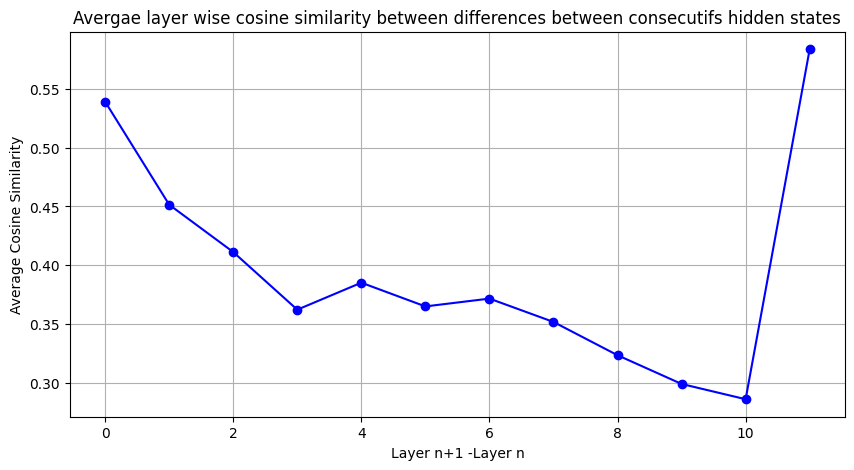

In [10]:
def compare_ffn_contributions(model_pre, model_post, dataloader):
    similarities = []
    
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        
        with torch.no_grad():
            pre_output = model_pre(**batch, output_hidden_states=True)
            pre_activations = pre_output.hidden_states
            post_output =model_post(**batch, output_hidden_states=True)
            post_activations = post_output.hidden_states
           # pre_logits=pre_output[1]
           # post_logits = post_output[1]

    
        pre_contribution = [pre_activations[i+1] - pre_activations[i] for i in range(0, len(pre_activations)-1)]
        post_contribution = [post_activations[i+1] - post_activations[i] for i in range(0, len(pre_activations) - 1)]

        similarities_hidden_states = [cosine_similarity(pre_contribution[layer], post_contribution[layer]) for layer in range(len(pre_contribution))]
      #  similarities_hidden_states.append(cosine_similarity(pre_logits - pre_activations[-1],post_logits - post_activations[-1]))
        del pre_activations
        del post_activations
        similarities.append(similarities_hidden_states)
        
    return np.mean(similarities, axis=0)


# Example usage
mean_similarity = compare_ffn_contributions(model_kb, model_hugging_face, valid_dataloader)
print(len(mean_similarity ))
print("Approximate FFN contribution similarity:", mean_similarity)

plot_results(mean_similarity,x_label='Layer n+1 -Layer n',title='Avergae layer wise cosine similarity between differences between consecutifs hidden states')

bert.encoder.layer.0.intermediate.dense.weight - Cosine Similarity: 0.7074416875839233
bert.encoder.layer.0.output.dense.weight - Cosine Similarity: 0.7112053036689758
bert.encoder.layer.1.intermediate.dense.weight - Cosine Similarity: 0.7712357044219971
bert.encoder.layer.1.output.dense.weight - Cosine Similarity: 0.729462206363678
bert.encoder.layer.2.intermediate.dense.weight - Cosine Similarity: 0.7854549884796143
bert.encoder.layer.2.output.dense.weight - Cosine Similarity: 0.7457582950592041
bert.encoder.layer.3.intermediate.dense.weight - Cosine Similarity: 0.7826400995254517
bert.encoder.layer.3.output.dense.weight - Cosine Similarity: 0.7515196800231934
bert.encoder.layer.4.intermediate.dense.weight - Cosine Similarity: 0.7909560799598694
bert.encoder.layer.4.output.dense.weight - Cosine Similarity: 0.763933002948761
bert.encoder.layer.5.intermediate.dense.weight - Cosine Similarity: 0.8016372323036194
bert.encoder.layer.5.output.dense.weight - Cosine Similarity: 0.77639365196

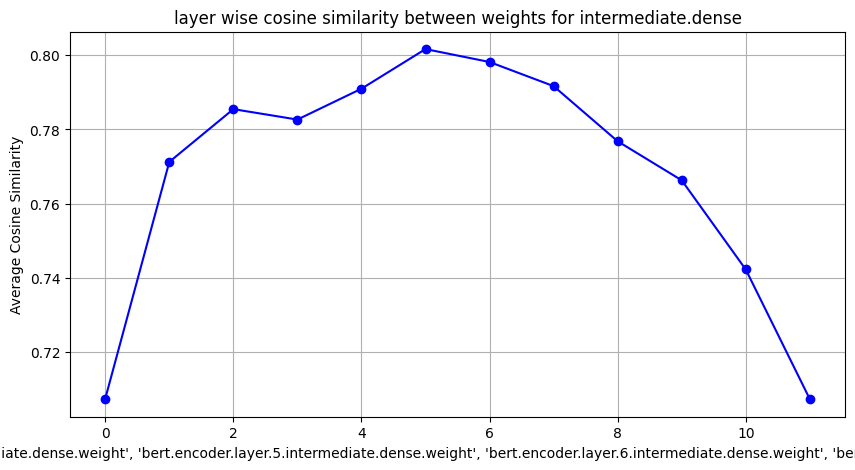

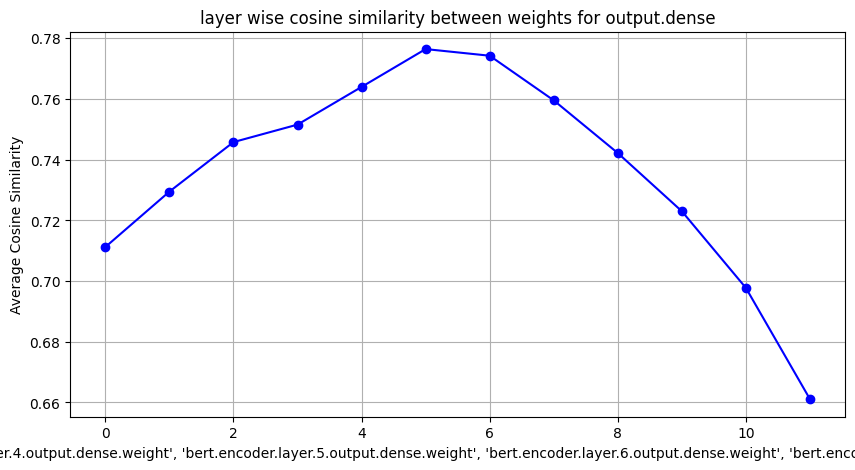

In [19]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np




def extract_and_compare_feed_forward_weights(model_pre, model_post, dataloader):
    similarities_intermediate = {}
    similarities_output = {}
    for (name_base, param_base), (name_fine, param_fine) in zip(model_kb.named_parameters(), model_hugging_face.named_parameters()):
        if "intermediate.dense.weight" in name_base :
            sim = cosine_similarity(param_base, param_fine)
            similarities_intermediate[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")
        if  "output.dense.weight" in name_base and "attention" not in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_output[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")

    return similarities_intermediate,similarities_output
       
def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()



def plot_results(similarities,label,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b',)
    plt.xlabel(label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_intermediate,mean_similarities_output = extract_and_compare_feed_forward_weights(model_kb, model_hugging_face, valid_dataloader)
similarity_intermediate=[mean_similarities_feed_froward[i] for i in mean_similarities_intermediate.keys()]
similarity_output=[mean_similarities_output[i] for i in mean_similarities_output.keys()]

print("Layer-wise cosine similarities:", mean_similarities_feed_froward)


plot_results(similarity_intermediate,label = mean_similarities_intermediate.keys(),title='layer wise cosine similarity between weights for intermediate.dense')
plot_results(similarity_output,label = mean_similarities_output.keys(),title='layer wise cosine similarity between weights for output.dense')


bert.encoder.layer.0.attention.self.value.bias - Cosine Similarity: 0.9391157627105713
bert.encoder.layer.1.attention.self.value.bias - Cosine Similarity: 0.979353129863739
bert.encoder.layer.2.attention.self.value.bias - Cosine Similarity: 0.9609243869781494
bert.encoder.layer.3.attention.self.value.bias - Cosine Similarity: 0.9628885984420776
bert.encoder.layer.4.attention.self.value.bias - Cosine Similarity: 0.9576257467269897
bert.encoder.layer.5.attention.self.value.bias - Cosine Similarity: 0.9767385721206665
bert.encoder.layer.6.attention.self.value.bias - Cosine Similarity: 0.9809153079986572
bert.encoder.layer.7.attention.self.value.bias - Cosine Similarity: 0.9810546636581421
bert.encoder.layer.8.attention.self.value.bias - Cosine Similarity: 0.9879538416862488
bert.encoder.layer.9.attention.self.value.bias - Cosine Similarity: 0.982791006565094
bert.encoder.layer.10.attention.self.value.bias - Cosine Similarity: 0.97950279712677
bert.encoder.layer.11.attention.self.value.bia

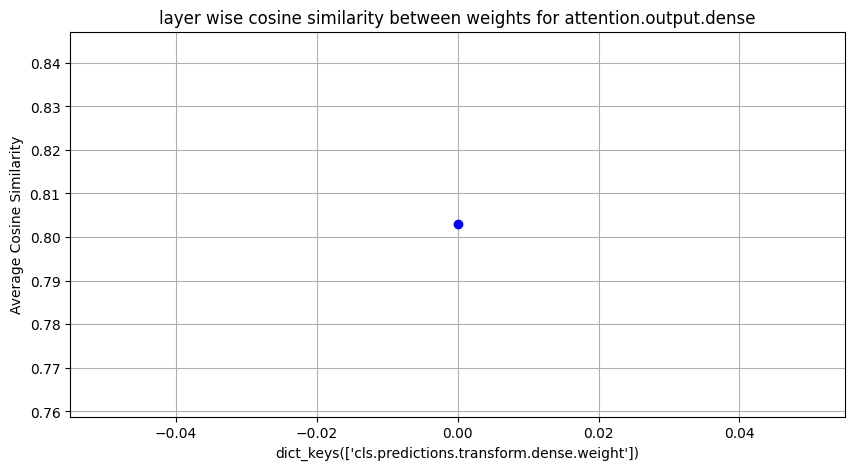

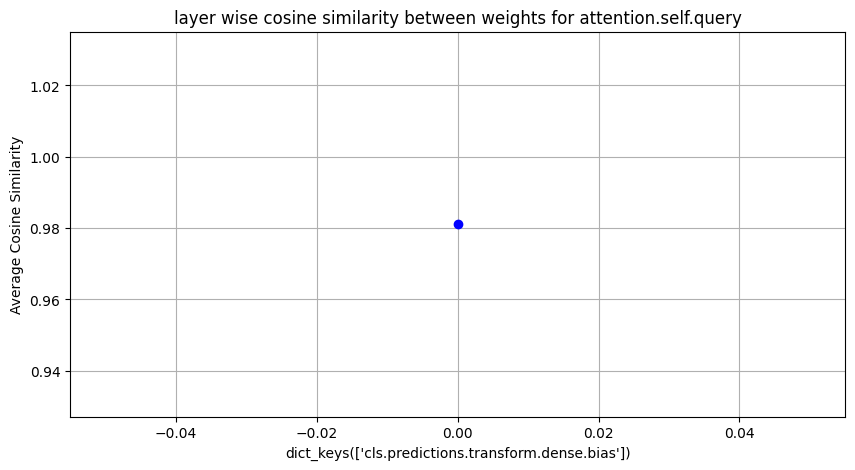

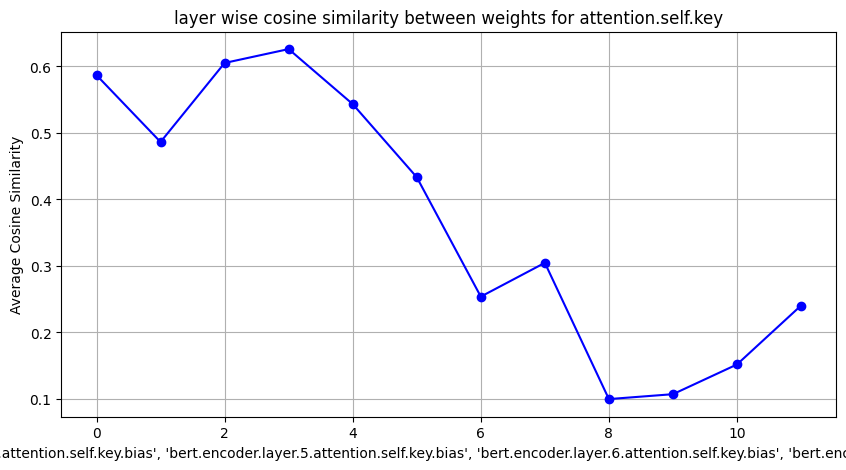

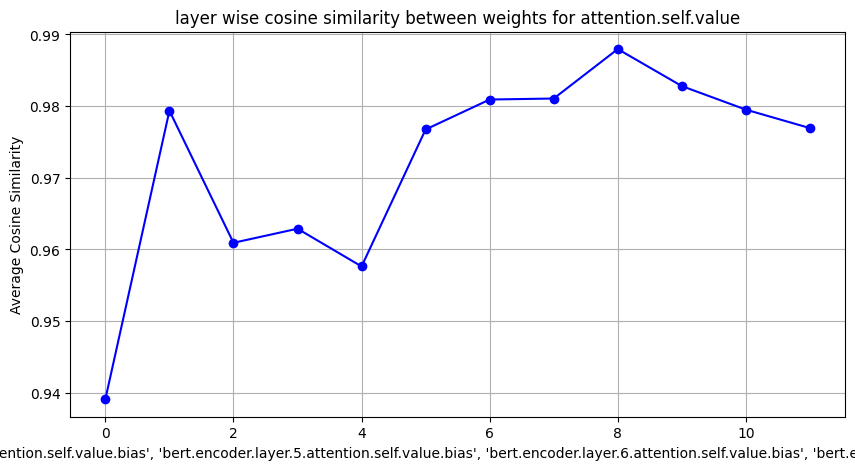

In [27]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np




def extract_and_compare_feed_forward_weights(model_pre, model_post, dataloader):
    similarities_attention = {}
    similarities_query = {}
    similarities_key = {}
    similarities_value = {}
    for (name_base, param_base), (name_fine, param_fine) in zip(model_kb.named_parameters(), model_hugging_face.named_parameters()):
        if "cls.predictions.transform.dense.weight" in name_base :
            sim = cosine_similarity(param_base, param_fine)
            similarities_attention[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")
        if  "cls.predictions.transform.dense.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_query[name_base]=sim
        if  "attention.self.key.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_key[name_base]=sim
        if  "attention.self.value.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_value[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")

    return similarities_attention,similarities_query,similarities_key,similarities_value
       
def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()



def plot_results(similarities,label,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b',)
    plt.xlabel(label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_attention,mean_similarities_query,mean_similarities_key,mean_similarities_value = extract_and_compare_feed_forward_weights(model_kb, model_hugging_face, valid_dataloader)
similarity_attention=[mean_similarities_attention[i] for i in mean_similarities_attention.keys()]
similarity_query=[mean_similarities_query[i] for i in mean_similarities_query.keys()]
similarity_key=[mean_similarities_key[i] for i in mean_similarities_key.keys()]
similarity_value=[mean_similarities_value[i] for i in mean_similarities_value.keys()]



plot_results(similarity_attention,label = mean_similarities_attention.keys(),title='layer wise cosine similarity between weights for attention.output.dense')
plot_results(similarity_query,label = mean_similarities_query.keys(),title='layer wise cosine similarity between weights for attention.self.query')
plot_results(similarity_key,label = mean_similarities_key.keys(),title='layer wise cosine similarity between weights for attention.self.key')
plot_results(similarity_value,label = mean_similarities_value.keys(),title='layer wise cosine similarity between weights for attention.self.value')


In [83]:
for name,param in model_hugging_face.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [97]:
data_file={"train":"evaluation/swerick_subsetdata_date_train.csv","test":"evaluation/swerick_subsetdata_date_test.csv"}
date_dataset=load_dataset("csv",data_files=data_file)
import pandas as pd
#date_dataset_train= pd.read_csv("evaluation/swerick_subsetdata_date_train.csv")
#date_dataset_test= pd.read_csv("evaluation/swerick_subsetdata_date_test.csv")

In [90]:
date_dataset_train["reform_label"]=date_dataset_train.apply(label_reform,axis=1)
date_dataset_test["reform_label"]=date_dataset_test.apply(label_reform,axis=1)

In [98]:
def label_reform(example):
    # Accéder à la colonne 'date' et comparer avec 1967
    if example['date'] > 1967:
        return {'reform_label':0}
    else:
        return  {'reform_label':1}

# Appliquer la fonction au dataset pour créer une nouvelle colonne 'reform_label'
date_dataset = date_dataset.map(label_reform)

Map: 100%|██████████| 10000/10000 [00:00<00:00, 19331.70 examples/s]


In [8]:
date_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'protocole', 'content', 'id', 'party', 'gender', 'date', 'tag', 'reform_label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'protocole', 'content', 'id', 'party', 'gender', 'date', 'tag', 'reform_label'],
        num_rows: 10000
    })
})

In [108]:
def get_embeddings(text,model):

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs,output_hidden_states=True)
        
    embeddings = outputs.hidden_states
    return embeddings

In [111]:
embeddings_train = [get_embeddings(phrase,model_kb) for phrase in date_dataset["train"]["content"][:5]]
print(len(embeddings_train))
print(len(embeddings_train[0]))
embeddings_test = [get_embeddings(phrase,model_kb) for phrase in date_dataset["test"]["content"][:5]]

5
13


In [119]:
#Edge probing : predicting noun  
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
        
def extract_and_classify(dataset, model,length):
    layer_accuracies = []
    with torch.no_grad():
        for layer_index in range(model.config.num_hidden_layers + 1):  # Include the embedding layer
            embeddings_train = [get_embeddings(phrase,model_kb) for phrase in dataset["train"]["content"][:length]]
            train_embeddings =[sentence[layer_index] for sentence in embeddings_train] 
            train_labels = date_dataset["train"]["reform_label"][:length]
            print(train_embeddings)
            print(len(train_labels))
            embeddings_test = [get_embeddings(phrase,model_kb) for phrase in dataset["test"]["content"][:length]]
            test_embeddings =[sentence[layer_index] for sentence in embeddings_test] 
            testlabels = date_dataset["test"]["reform_label"][:length]
    
            clf = LogisticRegression()
            clf.fit(train_embeddings, train_labels)
            y_pred = clf.predict(test_embeddings)

            # Calculate accuracy
            accuracy = accuracy_score(test_labels, y_pred)
            layer_accuracies.append((layer_index, accuracy))
    
    return layer_accuracies


accuracies = extract_and_classify(date_dataset, model_kb,5)

# Output the accuracies for each layer
for layer, acc in accuracies:
    print(f"Layer {layer}: Accuracy {acc}")




[tensor([[[ 0.1101,  0.2622,  0.0084,  ...,  0.3062, -0.0412,  0.1812],
         [ 1.2666, -0.2940, -0.0331,  ..., -0.6237,  0.3432,  0.5737],
         [-0.8237,  0.0761,  0.0825,  ...,  0.5604, -0.1844, -0.0307],
         ...,
         [ 0.1322, -0.6351, -1.2288,  ...,  0.5493,  0.5939,  1.2578],
         [ 0.2187, -0.4003, -0.5125,  ...,  0.7911, -0.0110,  1.6432],
         [-0.1456,  0.1719, -0.5099,  ...,  0.3111,  0.7196,  0.7269]]]), tensor([[[ 0.1101,  0.2622,  0.0084,  ...,  0.3062, -0.0412,  0.1812],
         [-0.9729,  0.5123, -0.6948,  ..., -0.1207,  1.6821,  0.5895],
         [-1.2366,  0.2432,  0.5324,  ...,  0.8467,  0.3965,  0.9674],
         ...,
         [ 0.1322, -0.6351, -1.2288,  ...,  0.5493,  0.5939,  1.2578],
         [ 0.2187, -0.4003, -0.5125,  ...,  0.7911, -0.0110,  1.6432],
         [-0.1456,  0.1719, -0.5099,  ...,  0.3111,  0.7196,  0.7269]]]), tensor([[[ 0.1101,  0.2622,  0.0084,  ...,  0.3062, -0.0412,  0.1812],
         [ 0.6706,  0.1918,  0.9901,  ...,

ValueError: Found array with dim 4. LogisticRegression expected <= 2.

In [124]:
train_embeddings =[sentence[1] for sentence in embeddings_train] 
len(train_embeddings[0][0][0])

768

In [151]:
input = date_dataset["train"]["content"][0]
input = tokenizer(input,return_tensors="pt", padding="max_length", truncation=True, max_length=512)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
input=data_collator([input])
collated_inputs = {key: value.squeeze(1) for key, value in input.items()}
output =model_kb(collated_inputs["input_ids"],attention_mask=collated_inputs["attention_mask"],labels =collated_inputs["labels"],output_hidden_states=True)
hidden_states = output.hidden_states



In [154]:
hidden_states[6].shape

torch.Size([1, 512, 768])

In [179]:
feature_vector = torch.mean(hidden_states[0], dim=1)
feature_vector.shape

torch.Size([1, 768])

In [163]:
def extract_features(examples,model):
  # take a batch of images
  images = examples['content']
  images = tokenizer(images,return_tensors="pt", padding="max_length", truncation=True, max_length=512)
  input=data_collator([images])
  collated_inputs = {key: value.squeeze(1) for key, value in input.items()}
  with torch.no_grad():
    output =model(collated_inputs["input_ids"],attention_mask=collated_inputs["attention_mask"],labels =collated_inputs["labels"],output_hidden_states=True)
  hidden_states = output.hidden_states
  # add features of each layer
  for i in range(len(hidden_states)):
      features = torch.mean(hidden_states[i], dim=1)
      examples[f'features_{i}'] = features.cpu().detach().numpy()
  
  return examples

In [167]:
encoded_dataset_train = Dataset.from_dict(date_dataset["train"][:20]).map(lambda example :extract_features(example,model_kb), batched=False)

Map: 100%|██████████| 20/20 [00:08<00:00,  2.36 examples/s]


In [168]:
encoded_dataset_test = Dataset.from_dict(date_dataset["test"][:20]).map(lambda example :extract_features(example,model_kb), batched=False)

Map: 100%|██████████| 20/20 [00:08<00:00,  2.31 examples/s]


In [191]:
encoded_dataset_train_bis=Dataset.from_dict(date_dataset["train"][:20]).map(lambda example :extract_features(example,model_hugging_face), batched=False)

Map: 100%|██████████| 20/20 [00:08<00:00,  2.35 examples/s]


In [192]:
encoded_dataset_test_bis = Dataset.from_dict(date_dataset["test"][:20]).map(lambda example :extract_features(example,model_hugging_face), batched=False)

Map: 100%|██████████| 20/20 [00:08<00:00,  2.33 examples/s]


In [184]:
encoded_dataset_train['features_0'][0][0]

[0.030141334980726242,
 -0.30972543358802795,
 -0.4245501756668091,
 0.3484519124031067,
 -0.4597941040992737,
 -1.115260124206543,
 -0.6771417856216431,
 0.34432610869407654,
 0.16317328810691833,
 -0.32854706048965454,
 0.6924622654914856,
 0.49039435386657715,
 0.13071975111961365,
 0.4699411988258362,
 -0.9213234186172485,
 0.4261077344417572,
 0.1075005829334259,
 -0.16538006067276,
 -0.41147810220718384,
 -0.43795472383499146,
 -0.8110237717628479,
 0.16422490775585175,
 -0.8517053127288818,
 0.2553987503051758,
 -0.0812043845653534,
 0.39241015911102295,
 0.48338091373443604,
 0.1337561309337616,
 0.3795424699783325,
 -0.5449131727218628,
 -0.5196213126182556,
 -0.07207034528255463,
 -0.6813897490501404,
 -0.8326866626739502,
 0.9586102962493896,
 -0.6315971612930298,
 -0.2969256639480591,
 -0.5471049547195435,
 -0.26663917303085327,
 0.35266971588134766,
 0.4303799271583557,
 0.16030646860599518,
 0.2514961361885071,
 -0.7406553030014038,
 0.7285194396972656,
 -0.30161893367767

In [193]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

train_dataset = encoded_dataset_train_bis
test_dataset = encoded_dataset_test_bis

scores = dict()
for i in range(model_kb.config.num_hidden_layers + 1):
    train_features = torch.Tensor(train_dataset[f'features_{i}']).squeeze(1)
    test_features = torch.Tensor(test_dataset[f'features_{i}']).squeeze(1)
    lr_clf = LogisticRegression(max_iter=1000)
    lr_clf.fit(train_features, train_dataset['reform_label'])
    # compute accuracy on training + test set
    training_score = lr_clf.score(train_features, train_dataset['reform_label'])
    test_score = lr_clf.score(test_features, test_dataset['reform_label'])
    scores[f'features_{i}'] = (training_score, test_score)


In [194]:
scores

{'features_0': (0.85, 0.55),
 'features_1': (1.0, 0.9),
 'features_2': (1.0, 0.85),
 'features_3': (1.0, 0.85),
 'features_4': (1.0, 0.85),
 'features_5': (1.0, 0.85),
 'features_6': (1.0, 0.85),
 'features_7': (1.0, 0.85),
 'features_8': (1.0, 0.85),
 'features_9': (1.0, 0.8),
 'features_10': (1.0, 0.75),
 'features_11': (1.0, 0.75),
 'features_12': (1.0, 0.7)}

In [190]:
scores

{'features_0': (0.85, 0.55),
 'features_1': (0.95, 0.7),
 'features_2': (1.0, 0.6),
 'features_3': (1.0, 0.6),
 'features_4': (1.0, 0.6),
 'features_5': (1.0, 0.6),
 'features_6': (1.0, 0.6),
 'features_7': (1.0, 0.65),
 'features_8': (1.0, 0.65),
 'features_9': (1.0, 0.65),
 'features_10': (1.0, 0.7),
 'features_11': (1.0, 0.85),
 'features_12': (1.0, 0.85)}